# RHF 核坐标梯度计算

上一节，我们对 RHF 下的偶极矩作了计算。我们求取了 Hamiltonian Core 矩阵、重叠矩阵、ERI 积分的 Skeleton 导数。我们利用过 U 矩阵的特性，避免计算了较为复杂和耗时的 U 矩阵，从而只利用概念相对简单的 Skeleton 导数就解决了偶极矩计算。

偶极矩也确实计算简单，并且可以从物理图景和一阶导数两种方式求得结果，因此可以作为一阶梯度计算不错的切入点。但也由于很多矩阵在电场下的导数为零，许多电场梯度所能给出的公式不能很好地推广到其它梯度响应性质，因此不是很好的切入点。在以后，我们会更多地使用核坐标梯度来引导学习各种响应性质。

由于分子轨道的 Skeleton 导数从定义上是原子轨道 Skeleton 导数与轨道系数缩并而来，因此我们只要了解原子轨道的 Skeleton 导数的具体求取过程即可。后文不会对分子轨道的 Skeleton 作很翔实的说明。

## 准备工作

与上一节的情况不同的是，我们这里是对核坐标梯度求导。因此，上一节的偶极矩辅助类实例 `diph` 在这里替换为了梯度辅助类实例 `gradh`。

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, lib
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt
from pyxdh.Utilities import NucCoordDerivGenerator, DipoleDerivGenerator, NumericDiff
from pyxdh.DerivOnce import GradSCF

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.5  0.0  0.0
H  0.0  0.7  1.5
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

In [3]:
gradh = GradSCF({"scf_eng": scf.RHF(mol)})

In [4]:
nmo, nao, natm, nocc, nvir = gradh.nao, gradh.nao, gradh.natm, gradh.nocc, gradh.nvir
so, sv, sa = gradh.so, gradh.sv, gradh.sa
C, Co, Cv, e, eo, ev, D = gradh.C, gradh.Co, gradh.Cv, gradh.e, gradh.eo, gradh.ev, gradh.D
H_0_ao, S_0_ao, eri0_ao, F_0_ao = gradh.H_0_ao, gradh.S_0_ao, gradh.eri0_ao, gradh.F_0_ao
H_0_mo, S_0_mo, eri0_mo, F_0_mo = gradh.H_0_mo, gradh.S_0_mo, gradh.eri0_mo, gradh.F_0_mo

In [5]:
def grad_generator(mol):
    scf_eng = scf.RHF(mol)
    config = {
        "scf_eng": scf_eng,
    }
    return GradSCF(config)

In [6]:
gradn = NucCoordDerivGenerator(mol, grad_generator)

## 重叠矩阵 Skeleton 导数

上一节我们先讨论了 Hamiltonian Core 导数；但在核坐标梯度中，Hamiltonian Core 导数并不是非常容易求取的。我们先讨论更为简单的重叠矩阵 Skeleton 导数。但即使重叠矩阵较为简单，其过程可能也会令新读者感到相当痛苦。

### 解析导数 (1) 额外符号的引入

重叠积分的定义是

$$
S_{\mu \nu} = \langle \mu | \nu \rangle = \int \phi_{\mu} (\boldsymbol{r}) \phi_{\nu} (\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}
$$

但是从上面的定义中，我们似乎看不到任何与核坐标有关的变量。

事实上，原子轨道作为 Gaussian 函数基组，它的定义还与其对应的原子核坐标有关。因此，我们可以对原子轨道角标 $\mu, \nu$ 下方明确加上原子角标，并将函数的自变量写为电子坐标与基组中心的原子核坐标之差的形式：

$$
S_{\mu \nu} = \int \phi_{\mu_{M_1}} (\boldsymbol{r} - \boldsymbol{M}_1) \phi_{\nu_{M_2}} (\boldsymbol{r} - \boldsymbol{M}_2) \, \mathrm{d} \boldsymbol{r}
$$

需要说明，下标 $M_1, M_2$ 只是表明原子轨道 $\mu$ 的中心在原子 $M_1$ 上，原子轨道 $\nu$ 的中心在原子 $M_2$ 上。

<div class="alert alert-info">

**记号说明**

- 原子轨道下标原子角标 $\mu_M$：
    
    - 若原子 $M$ 是原子轨道 $\mu$ 作为 Gaussian 函数的中心，那么该角标的矩阵或张量值可能非零；
    
    - 但若 $M$ 并非 $\mu$ 的中心，那么矩阵或张量值一定为零。

这个符号有一点点类似于 Kronecker $\delta$ 函数。如果我们不用 Einstein Summation 而只使用普通求和，那么用刚才的符号，下述表达式成立：

$$
S_{\mu \nu}
= \int \phi_\mu \phi_\nu \, \mathrm{d} \boldsymbol{r}
= \sum_{M_1, M_2} \int \phi_{\mu_{M_1}} \phi_{\nu_{M_2}} \, \mathrm{d} \boldsymbol{r}
$$

</div>

现在，我们对上式作关于原子核 $A$ 的 $t$ 坐标分量的导数：

$$
S_{\mu \nu}^{A_t} = \frac{\partial S_{\mu \nu}}{\partial A_t} =
\int \frac{\partial \phi_{\mu_{M_1}} (\boldsymbol{r} - \boldsymbol{M}_1)}{\partial A_t} \phi_{\nu_{M_2}} (\boldsymbol{r} - \boldsymbol{M}_2) \, \mathrm{d} \boldsymbol{r} +
\int \phi_{\mu_{M_1}} (\boldsymbol{r} - \boldsymbol{M}_1) \frac{\partial \phi_{\nu_{M_2}} (\boldsymbol{r} - \boldsymbol{M}_2)}{\partial A_t} \, \mathrm{d} \boldsymbol{r}
$$

上式多少有些冗长。事实上，上式的两项非常相似，差别仅仅是交换了 $\mu, \nu$ 而已。我们以后经常会使用如下记号简写：

$$
S_{\mu \nu}^{A_t} =
\int \frac{\partial \phi_{\mu_{M_1}} (\boldsymbol{r} - \boldsymbol{M}_1)}{\partial A_t} \phi_{\nu_{M_2}} (\boldsymbol{r} - \boldsymbol{M}_2) \, \mathrm{d} \boldsymbol{r} +
\mathrm{swap} (\mu, \nu)
$$

### $S_{\mu \nu}^{A_t}$ 稀疏性 (1) 程序结果演示

在继续讨论之前，我们不妨先看一看重叠矩阵 Skeleton 导数的一些特性。`gradh.S_1_ao` 是 pyxdh 所生成的解析的 $S_{\mu \nu}^\mathbb{A}$，其维度 $(\mathbb{A}, \mu, \nu)$ 如下：

In [7]:
gradh.S_1_ao.shape

(12, 22, 22)

其第一个维度 $\mathbb{A}$ 相当于原子核的坐标分量 $A_t$，但被压成了一个维度。因此，若要取索引为 1 的原子 (第二个氧原子) 的 $z$ 分量，则应当取 `gradh.S_1_ao[5]`。

但这个矩阵仍然很庞大，我们不妨将这个矩阵拆开来看。

我们首先取出 `gradh.S_1_ao[5]` 上述矩阵的索引 $[9, 18)$ 行、索引 $[0, 9) \cup [18, 22)$ 列；这是上述矩阵 (除开其转置之外) 唯一有非零值的地方：

In [8]:
slice_mu = range(9, 18)
slice_nu = (*range(0, 9), *range(18, 22))
gradh.S_1_ao[5][slice_mu, :][:, slice_nu]

array([[-0.     , -0.00166, -0.03032,  0.     ,  0.     , -0.00498,  0.     ,  0.     , -0.06593, -0.00006, -0.00817, -0.     ,  0.     ],
       [-0.00166, -0.0604 , -0.16854,  0.     ,  0.     , -0.10281,  0.     ,  0.     , -0.27194, -0.00356, -0.05094, -0.     ,  0.     ],
       [-0.03032, -0.16854, -0.25868,  0.     ,  0.     , -0.11283,  0.     ,  0.     , -0.20539, -0.0389 , -0.10756,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , -0.02832,  0.     ,  0.     , -0.1074 ,  0.     ,  0.     , -0.00526, -0.03049,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     , -0.02832,  0.     ,  0.     , -0.1074 ,  0.     ,  0.     ,  0.     , -0.     , -0.     ],
       [ 0.00498,  0.10281,  0.11283,  0.     ,  0.     ,  0.15701,  0.     ,  0.     ,  0.05342,  0.00443,  0.01699, -0.32959, -0.10123],
       [ 0.     ,  0.     ,  0.     , -0.1074 ,  0.     ,  0.     , -0.25868,  0.     ,  0.     , -0.08229, -0.11849,  0.     ,  0.     ],
       [ 0.     ,  0.     ,

其它的矩阵元的值近乎于为零。我们可以将矩阵元的绝对值和减去两倍上面子矩阵的矩阵元绝对值和，得到接近于 0 的结果：

In [9]:
np.abs(gradh.S_1_ao[5]).sum() - 2 * np.abs(gradh.S_1_ao[5][slice_mu, :][:, slice_nu]).sum()

2.3092638912203256e-14

因此，其实相当多的矩阵元是零值。

这对于其它的原子核也是类似的。

这种现象并非是偶然的。我们先回忆一下很早之前提及的 [原子轨道分割](../qcbasic/basis_integral.ipynb#壳层分割与原子轨道分割)。

In [10]:
mol.aoslice_by_atom()

array([[ 0,  5,  0,  9],
       [ 5, 10,  9, 18],
       [10, 12, 18, 20],
       [12, 14, 20, 22]])

因此，上述的非零的矩阵元所代表的的是，$\mu$ 所代表的原子是第 2 个氧原子，$\nu$ 所代表的原子是第 1 个氧原子和其它氢原子时，矩阵元是非零的。

我们以后会为了便利，使用 `mol_slice` 函数给出原子轨道的分割：

In [11]:
def mol_slice(atm_id, mol=mol):
    _, _, p0, p1 = mol.aoslice_by_atom()[atm_id]
    return slice(p0, p1)

譬如，我们要取出第二个氧原子 (索引为 1 的原子) 的所有原子轨道的话，下述代码就可以取出其分割：

In [12]:
mol_slice(1)

slice(9, 18, None)

### 解析导数 (2) 最终表达式

接下来，我们看看为什么这么多矩阵元的值为零。我们先对下式作讨论。

$$
\frac{\partial \phi_{\mu_{M_1}} (\boldsymbol{r} - \boldsymbol{M}_1)}{\partial A_t} \phi_{\nu_{M_2}} (\boldsymbol{r} - \boldsymbol{M}_2)
$$

我们定义 $\boldsymbol{u} = \boldsymbol{r} - \boldsymbol{M}_1$，那么根据链式法则，

$$
\frac{\partial \phi_{\mu_{M_1}} (\boldsymbol{r} - \boldsymbol{M}_1)}{\partial A_t}
= \frac{\partial \phi_{\mu_{M_1}} (\boldsymbol{u})}{\partial A_t} = \frac{\partial \phi_{\mu_{M_1}} (\boldsymbol{u})}{\partial \boldsymbol{u}} \cdot \frac{\partial \boldsymbol{u}}{\partial A_t}
$$

先考察 $\partial_{A_t} \boldsymbol{u}$。由于 $\boldsymbol{r}$ 是电子坐标，与原子核坐标分量 $A_t$ 无关，因此

$$
\frac{\partial \boldsymbol{r}}{\partial A_t} = \boldsymbol{0}
$$

而若 $M_1$ 作为原子与原子 $A$ 不同，那么 $\boldsymbol{M}_1$ 也与 $A_t$ 毫无关系：

$$
\frac{\partial \boldsymbol{M}_1}{\partial A_t} = \boldsymbol{0} \quad (M_1 \neq A)
$$

但若 $M_1$ 就是原子 $A$，或者说原子轨道 $\mu$ 的中心恰好是 $A$ 原子，那么

$$
\frac{\partial \boldsymbol{M}_1}{\partial A_t} = (\delta_{tx}, \delta_{ty}, \delta_{tz}) \quad (M_1 = A)
$$

之所以写成上式的形式，是因为首先我们注意到 $\boldsymbol{M}_1 = \boldsymbol{A}$ 本身是原子坐标，具有三个分量；如果我们将 $A_t$ 当作标量考虑，那么上述偏导结果还是三元素向量。

那么，我们可以将 $\boldsymbol{A}$ 写成向量 $(A_x, A_y, A_z)$ 的形式。$A_t$ 就是其中的一个分量；因此，求导的结果就是 $A_t$ 所在分量导数为 1，其余两个分量导数为零。这可以写成 Kronecker $\delta$ 的形式。

那么综合起来，我们可以写

$$
\frac{\partial \boldsymbol{u}}{\partial A_t} = - \frac{\partial \boldsymbol{M}_1}{\partial A_t} = - \delta_{M_1 A} (\delta_{tx}, \delta_{ty}, \delta_{tz})
$$

这也就意味着只有三维坐标 $\boldsymbol{u}$ 中只有 $u_t$ 会对偏导产生贡献。因此，

$$
\frac{\partial \phi_{\mu_{M_1}} (\boldsymbol{r} - \boldsymbol{M}_1)}{\partial A_t}
= \frac{\partial \phi_{\mu_{M_1}} (\boldsymbol{u})}{\partial \boldsymbol{u}} \cdot \frac{\partial \boldsymbol{u}}{\partial A_t}
= - \frac{\partial \phi_{\mu_{M_1}} (\boldsymbol{u})}{\partial u_t} \delta_{M_1 A}
= - \frac{\partial \phi_{\mu_A} (\boldsymbol{u})}{\partial u_t}
$$

化简至此，我们认为基本就够了。我们通常会将上式再缩写为

$$
\frac{\partial \phi_{\mu_{M_1}} (\boldsymbol{r} - \boldsymbol{M}_1)}{\partial A_t} = - \phi_{t \mu_A}
$$

其中，简写记号 $\phi_{t \mu_A}$ 意味着原子轨道 $\mu$ 只在原子 $A$ 上才显示有值，且该原子轨道被求过 $t$ 方向的偏导数。

我们回顾这一段最初的问题，即重叠矩阵的 Skeleton 导数：

$$
\begin{align}
S_{\mu \nu}^{A_t}
&= \int \frac{\partial \phi_{\mu_{M_1}} (\boldsymbol{r} - \boldsymbol{M}_1)}{\partial A_t} \phi_{\nu_{M_2}} (\boldsymbol{r} - \boldsymbol{M}_2) \, \mathrm{d} \boldsymbol{r} +
\mathrm{swap} (\mu, \nu) \\
&= - \int \phi_{t \mu_A} \phi_\nu \, \mathrm{d} \boldsymbol{r} + \mathrm{swap} (\mu, \nu) \\
&= - \langle \partial_t \mu_A | \nu \rangle + \mathrm{swap} (\mu, \nu)
\end{align}
$$

上面的表达式回答了为何 $S_{\mu \nu}^{A_t}$ 有这么多零值。这是因为，若 $\mu$ 作为 Gaussian 函数的中心不是原子核 $A$，那么 $\langle \partial_t \mu_A | \nu \rangle$ 为零值。即使说还有 $\mathrm{swap} (\mu, \nu)$，但这个补上去的转置也仍然不会改变 $S_{\mu \nu}^{A_t}$ 是一个零值非常多的矩阵的状况。

不仅仅是 $S_{\mu \nu}^{A_t}$，其它的不少 Skeleton 导数都具有这种稀疏性。尽管储存这种稀疏的矩阵一般来说总是低效的，但为了程序方便，我们通常都明确地在程序中使用稠密矩阵来储存这类稀疏矩阵。

在这一小段的最后，我们回顾一下上述推导过程中，一个很常用的推论：

<div class="alert alert-info">

**常用推论**

$$
\partial_{A_t} \mu = - \partial_t \mu_A
$$

</div>

### 解析导数 (3) 程序

所幸的是，PySCF 中，支持对 $\langle \partial_t \mu | \nu \rangle$ 积分的计算。该积分可以暂存为 `int1e_ipovlp`：

In [13]:
int1e_ipovlp = mol.intor("int1e_ipovlp")
int1e_ipovlp.shape

(3, 22, 22)

但这甚至与我们所期望的 $S_{\mu \nu}^{A_t}$ 的维度也完全不同；`int1e_ovlp` $\langle \partial_t \mu | \nu \rangle$ 的维度是 $(t, \mu, \nu)$，而 $S_{\mu \nu}^{A_t}$ 的维度应当是 $(A, t, \mu, \nu)$ 或 $(\mathbb{A} = A_t, \mu, \nu)$。

这是因为 $\langle \partial_t \mu | \nu \rangle$ 并不等同于 $\langle \partial_t \mu_A | \nu \rangle$；后者引入了原子轨道和原子之间的关系。譬如，对于 $A$ 为第 2 个氧原子 (索引 1 的原子) 而言，$\langle \partial_t \mu_A | \nu \rangle$ 积分中，当 $\mu$ 处在其它原子上时，矩阵元应当都为零。我们可以用下述代码生成 $A$ 为第 2 个氧原子的 `S_1_ao_atom1` $S_{\mu \nu}^{A_t}$ (维度为 $(t, \mu, \nu)$)：

In [14]:
S_1_ao_atom1 = np.zeros((3, nao, nao))
sA = mol_slice(1)
S_1_ao_atom1[:, sA, :] = - int1e_ipovlp[:, sA, :]
S_1_ao_atom1 += S_1_ao_atom1.swapaxes(-1, -2)
np.allclose(S_1_ao_atom1, gradh.S_1_ao[3:6])

True

上述代码的

- Line 1：生成维度为 $(t, \mu, \nu)$ 的零矩阵；

- Line 2：给出第二个氧原子为中心的所有原子轨道 $\mu_A$ 的索引；

- Line 3：对所有处在原子 $A$ 上的原子轨道 $\mu$，赋值 $-\langle \partial_t \mu | \nu \rangle$；

- Line 4：处理 $\mathrm{swap}(\mu, \nu)$

- Line 5：与真实结果进行比对。

那么，对上面的程序作一点点延伸，就可以给出完整的、所有原子的 `S_1_ao` $S_{\mu \nu}^{A_t}$ 了 (维度 $(A, t, \mu, \nu)$)：

In [15]:
S_1_ao = np.zeros((natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    S_1_ao[A, :, sA, :] = - int1e_ipovlp[:, sA, :]
S_1_ao += S_1_ao.swapaxes(-1, -2)

我们可以将其与 pyxdh 所给出的 `gradh.S_1_ao` 作比较；但在此之前，我们注意到两者维度不同：

In [16]:
print("Our's S_1_ao:", S_1_ao.shape)
print("pyxdh S_1_ao:", gradh.S_1_ao.shape)

Our's S_1_ao: (4, 3, 22, 22)
pyxdh S_1_ao: (12, 22, 22)


这是因为 pyxdh 使用 $\mathbb{A} = A_t$ 的方式存储各种解析导数，因此会将 $(A, t)$ 组合为一个维度。这么做在一阶响应性质中会是累赘，但在二阶响应性质的推导和编写上会轻松不少。我们在以后的一阶响应性质的文档中，统一还是拆分 $(A, t)$ 作为两个维度考虑。

那么，为比较上述两个张量是否相等，可以完全压平再进行比较：

In [17]:
np.allclose(S_1_ao.flatten(), gradh.S_1_ao.flatten())

True

### $S_{\mu \nu}^{A_t}$ 稀疏性 (2) 详细解释

我们刚才已经推导过，

$$
\begin{align}
S_{\mu \nu}^{A_t}
&= - \langle \partial_t \mu_A | \nu \rangle + \mathrm{swap} (\mu, \nu) \\
&= - \langle \partial_t \mu_A | \nu \rangle - \langle \mu | \partial_t \nu_A \rangle
\end{align}
$$

因此，容易知道对于原子 $A$ 来讲，$S^{A_t}_{\mu \nu}$ 中，若 $\mu \neq A$ 且 $\nu \neq A$，则 $S_{\mu \nu}^{A_t} = 0$。下面展示的是，当 $A$ 是第 2 个氧原子 (索引 1) 且 $t = z$ 分量时，$S_{\mu \nu}^{A_t}$ 中所有 $\mu \neq A$ 且 $\nu \neq A$ 的元素值：

In [18]:
slice_mu = list(range(nao))[mol_slice(0)] + list(range(nao))[mol_slice(2)] + list(range(nao))[mol_slice(3)]
slice_nu = list(range(nao))[mol_slice(0)] + list(range(nao))[mol_slice(2)] + list(range(nao))[mol_slice(3)]
S_1_ao[1, 2][slice_mu, :][:, slice_nu]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

剩下的元素全部都可能非零吗？并非如此。$S^{A_t}_{\mu \nu}$ 中，若 $\mu = A$ 且 $\nu = A$，仍然有 $S_{\mu \nu}^{A_t} = 0$。

In [19]:
slice_mu = mol_slice(1)
slice_nu = mol_slice(1)
S_1_ao[1, 2][slice_mu, :][:, slice_nu]

array([[ 0., -0.,  0., -0., -0.,  0., -0., -0.,  0.],
       [-0., -0., -0., -0., -0., -0., -0., -0.,  0.],
       [ 0., -0., -0., -0., -0., -0., -0., -0.,  0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 0.,  0.,  0., -0., -0., -0., -0., -0., -0.]])

<div class="alert alert-info">

**任务 (1)**

证明

$$
\langle \partial_t \mu_A | \nu_A \rangle + \mathrm{swap} (\mu, \nu) = 0
$$

</div>

其它的情况 ($\mu = A$ 且 $\nu \neq A$，或 $\mu \neq A$ 且 $\nu = A$) 则未必为零值；但完全可能因为分子或原子轨道对称性，导致零值的产生。这种零值我们就不作讨论了。

### 数值导数

最后，我们用数值导数与解析导数相互验证来收尾这一段。定义数值导数 `nd_S_0_ao` $\partial_{A_t} S_{\mu \nu}$：

In [20]:
nd_S_0_ao = NumericDiff(gradn, lambda gradh: gradh.S_0_ao).derivative
nd_S_0_ao.shape

(12, 22, 22)

像上一节一样，我们绘制其与方才计算得到的 `S_1_ao` $S_{\mu \nu}^t$ 的误差图：

<IPython.core.display.Javascript object>


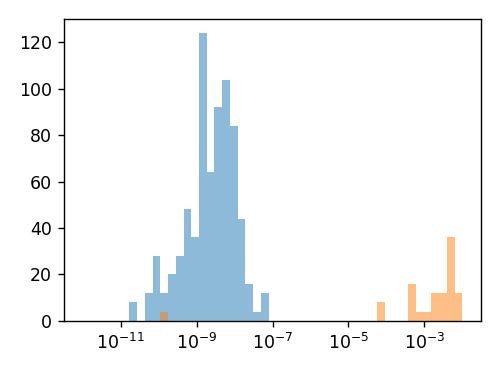

In [21]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(nd_S_0_ao.ravel() - S_1_ao.ravel()), bins=np.logspace(np.log10(1e-12), np.log10(1e-2), 50), alpha=0.5)
ax.hist(abs(nd_S_0_ao.ravel()), bins=np.logspace(np.log10(1e-12), np.log10(1e-2), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

## Hamiltonian Core 导数

### 解析梯度 (1) 原子轨道导数

Hamiltonian Core 定义为

$$
\hat h = \hat t + \hat v_\mathrm{nuc}
$$

我们先考虑动能积分：

$$
\begin{align}
h_{\mu \nu}^{A_t} &\leftarrow \frac{\partial}{\partial A_t} \langle \mu | \hat t | \nu \rangle \\
&= \langle \partial_{A_t} \mu | \hat t | \nu \rangle + \mathrm{swap} (\mu, \nu) \\
&= - \langle \partial_t \mu_A | \hat t | \nu \rangle + \mathrm{swap} (\mu, \nu)
\end{align}
$$

上面的第 3 行导出过程中，我们利用到了 $\partial_{A_t} \mu = - \partial_t \mu_A$ 的结论。

<div class="alert alert-info">

**任务 (2)**

请用简单的语言，简述为何下式为零：

$$
\langle \mu_A | \partial_{A_t} \hat t | \nu_A \rangle = 0
$$

</div>

其中，$\langle \partial_t \mu | \hat t | \nu \rangle$ 积分在 PySCF 中可以通过 `int1e_ipkin` 获得。因此，动能部分的贡献大小是 `H_1_ao_kin`：

In [22]:
int1e_ipkin = mol.intor("int1e_ipkin")
H_1_ao_kin = np.zeros((natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    H_1_ao_kin[A, :, sA, :] = - int1e_ipkin[:, sA, :]
H_1_ao_kin += H_1_ao_kin.swapaxes(-1, -2)

随后我们考虑势能积分：

$$
\begin{align}
h_{\mu \nu}^{A_t} &\leftarrow \frac{\partial}{\partial A_t} \langle \mu | \hat v_\mathrm{nuc} | \nu \rangle \\
&= \langle \partial_{A_t} \mu | \hat v_\mathrm{nuc} | \nu \rangle + \langle \mu | \hat v_\mathrm{nuc} | \partial_{A_t} \nu \rangle + \langle \mu | \partial_{A_t} \hat v_\mathrm{nuc} | \nu \rangle
\end{align}
$$

我们指出，在势能积分中，$\langle \mu | \partial_{A_t} \hat v_\mathrm{nuc} | \nu \rangle$ 一项并非是零；而这一项考虑起来也稍复杂一些，我们放在下一小段中叙述。这里我们先生成前两项的贡献大小 `H_1_ao_nuc1`：

$$
h_{\mu \nu}^{A_t} \leftarrow - \langle \partial_t \mu_A | \hat v_\mathrm{nuc} | \nu \rangle + \mathrm{swap} (\mu, \nu)
$$

其中，$\langle \partial_t \mu | \hat v_\mathrm{nuc} | \nu \rangle$ 积分在 PySCF 中可以通过 `int1e_ipnuc` 获得：

In [23]:
int1e_ipnuc = mol.intor("int1e_ipnuc")
H_1_ao_nuc1 = np.zeros((natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    H_1_ao_nuc1[A, :, sA, :] = - int1e_ipnuc[:, sA, :]
H_1_ao_nuc1 += H_1_ao_nuc1.swapaxes(-1, -2)

### 解析导数 (2) 核静电势算符导数

这里我们处理 $\langle \mu | \partial_{A_t} \hat v_\mathrm{nuc} | \nu \rangle$ 的计算。这里我们暂时不用 Einstein Summation。

我们回顾到

$$
\hat v_\mathrm{nuc} = - \sum_M \frac{Z_M}{| \boldsymbol{r} - \boldsymbol{M} |}
$$

上式是对原子核索引 $M$ 求和。由于算符 $v_\mathrm{nuc}$ 不像偏导算符，$v_\mathrm{nuc}$ 可以当作数来对待，因此单独分析 $\partial_{A_t} \hat v_\mathrm{nuc}$ 是有意义的。那么，

$$
\partial_{A_t} \hat v_\mathrm{nuc} = - \sum_M \frac{\partial}{\partial A_t} \frac{Z_M}{| \boldsymbol{r} - \boldsymbol{M} |}
$$

上式中，有可能与 $A_t$ 产生联系的只可能是 $M$ 原子核坐标 $\boldsymbol{M}$。参考 $S_{\mu \nu}^{A_t}$ 导出过程分析，我们知道，若 $M \neq A$，那么两者就无关了。因此，只有当 $M = A$ 时才能产生导数：

$$
\partial_{A_t} \hat v_\mathrm{nuc} = - \frac{\partial}{\partial A_t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |}
$$

注意到上式并没有对任何角标作求和。下面我们利用一个小技巧，将关于 $A_t$ (原子核坐标分量) 的导数转为关于 $t$ (电子坐标分量) 的导数：

$$
\frac{\partial}{\partial t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} = - \frac{\partial}{\partial A_t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |}
$$

<div class="alert alert-info">

**任务 (3)**

请尝试证明上述等式。

</div>

因此，

$$
\langle \mu | \partial_{A_t} \hat v_\mathrm{nuc} | \nu \rangle = \langle \mu | \frac{\partial}{\partial t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} | \nu \rangle
$$

我们固然可以利用任务 (3) 的结论求取上述积分结果；但这不仅困难，而且 PySCF 中事实上没有提供类似于 $\langle \mu | r^3 | \nu \rangle$ 的积分程序。

我们再使用一个小技巧：

$$
\begin{align}
\langle \mu | \partial_{A_t} \hat v_\mathrm{nuc} | \nu \rangle
&= \int \phi_\mu \phi_\nu \frac{\partial}{\partial t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} \, \mathrm{d} \boldsymbol{r} \\
&= - \int \frac{\partial}{\partial t} (\phi_\mu \phi_\nu) \cdot \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} \, \mathrm{d} \boldsymbol{r} \\
&= - \langle \partial_t \mu | \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} | \nu \rangle + \mathrm{swap} (\mu, \nu)
\end{align}
$$

在 PySCF 中， $\langle \partial_t \mu | r^{-1} | \nu \rangle$ 的积分可以用 `int1e_iprinv` 调出。我们知道，对于上面 $|\boldsymbol{r} - \boldsymbol{A}|^{-1}$ 这种情况，积分的求取需要先将原点移动至 $A$ 原子坐标即 $\boldsymbol{A}$。这个程序的技巧在 [核排斥势积分](../qcbasic/basic_rhf.ipynb#核排斥势积分) 有所提及。我们将上述积分的结果储存在 `H_1_ao_nuc2` 中：

In [24]:
H_1_ao_nuc2 = np.zeros((natm, 3, nao, nao))
Z_A = mol.atom_charges()
for A in range(natm):
    with mol.with_rinv_as_nucleus(A):
        H_1_ao_nuc2[A] -= Z_A[A] * mol.intor("int1e_iprinv")
H_1_ao_nuc2 += H_1_ao_nuc2.swapaxes(-1, -2)

<div class="alert alert-info">

**任务 (4)**

请尝试证明上述推导过程的第二个等号：

$$
\int \phi_\mu \phi_\nu \frac{\partial}{\partial t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} \, \mathrm{d} \boldsymbol{r}
= - \int \frac{\partial}{\partial t} (\phi_\mu \phi_\nu) \cdot \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} \, \mathrm{d} \boldsymbol{r}
$$

</div>

<div class="alert alert-info">

**任务 (5)**

读者可能在这里意识到了，之所以我们利用下述小技巧 (将偏导从对原子分量偏导 $\partial_{A_t}$ 转为对电子坐标分量偏导)

$$
\frac{\partial}{\partial t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} = - \frac{\partial}{\partial A_t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |}
$$

是为了进一步证明任务 (4) 中所指出的公式。

不利用上面的小技巧事实上很难推演出能程序化的表达式。退一步说，下述等式为何一般地不成立？

$$
\int \phi_\mu \phi_\nu \frac{\partial}{\partial A_t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} \, \mathrm{d} \boldsymbol{r}
\not \equiv - \int \frac{\partial}{\partial A_t} (\phi_\mu \phi_\nu) \cdot \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} \, \mathrm{d} \boldsymbol{r}
$$

</div>

### 解析梯度总结与数值梯度

至此，我们已经将所有的 $h_{\mu \nu}^{A_t}$ 的贡献项求取完毕了：

$$
h_{\mu \nu}^{A_t} = - \langle \partial_t \mu_A | \hat t | \nu \rangle - \langle \partial_t \mu_A | \hat v_\mathrm{nuc} | \nu \rangle - \langle \partial_t \mu | \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} | \nu \rangle + \mathrm{swap} (\mu, \nu)
$$

综合上面几段代码，我们可以通过下述方式实现 `H_1_ao` $h_{\mu \nu}^{A_t}$：

In [25]:
int1e_ipkin = mol.intor("int1e_ipkin")
int1e_ipnuc = mol.intor("int1e_ipnuc")
Z_A = mol.atom_charges()

In [26]:
H_1_ao = np.zeros((natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    H_1_ao[A, :, sA, :] -= int1e_ipkin[:, sA, :]
    H_1_ao[A, :, sA, :] -= int1e_ipnuc[:, sA, :]
    with mol.with_rinv_as_nucleus(A):
        H_1_ao[A] -= Z_A[A] * mol.intor("int1e_iprinv")
H_1_ao += H_1_ao.swapaxes(-1, -2)

这与 pyxdh 所实现的 $h_{\mu \nu}^{A_t}$ 完全一致：

In [27]:
np.allclose(H_1_ao.ravel(), gradh.H_1_ao.ravel())

True

我们也可以通过数值导数的方法生成 `nd_H_0_ao` $\partial_{A_t} h_{\mu \nu}$ 并用图像验证其与 `H_1_ao` $h_{\mu \nu}^{A_t}$ 非常接近：

In [28]:
nd_H_0_ao = NumericDiff(gradn, lambda gradh: gradh.H_0_ao).derivative
nd_H_0_ao.shape

(12, 22, 22)

<IPython.core.display.Javascript object>


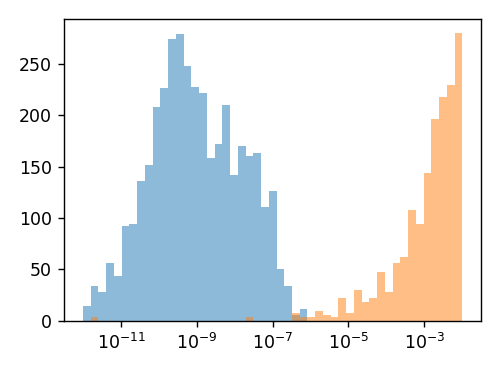

In [29]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(nd_H_0_ao.ravel() - H_1_ao.ravel()), bins=np.logspace(np.log10(1e-12), np.log10(1e-2), 50), alpha=0.5)
ax.hist(abs(nd_H_0_ao.ravel()), bins=np.logspace(np.log10(1e-12), np.log10(1e-2), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

## ERI 积分导数

### 解析导数

我们借助 $\partial_{A_t} \mu = \partial_t \mu_A$ 的结论，可以得到

$$
\begin{align}
(\mu \nu | \kappa \lambda)^{A_t} = \frac{\partial}{\partial A_t} (\mu \nu | \kappa \lambda) &= - \big[ (\partial_t \mu_A \nu | \kappa \lambda) + (\mu \partial_t \nu_A | \kappa \lambda) + (\mu \nu | \partial_t \kappa_A \lambda) + (\mu \nu | \kappa \partial_t \lambda_A) \big] \\
&= - (\partial_t \mu_A \nu | \kappa \lambda) + \mathrm{swap} (\mu, \nu) + \mathrm{swap} (\mu \nu, \kappa \lambda)
\end{align}
$$

上面展示了两种 ERI 积分的导数表达式，分别对应了两种程序实现 `eri1_ao` $(\mu \nu | \kappa \lambda)^{A_t}$ 的方式。第一种采用第一行的思路；其中，我们利用到 PySCF 中 $(\partial_t \mu \nu | \kappa \lambda)$ 可以用 `int2e_ip1` 调出：

In [30]:
int2e_ip1 = mol.intor("int2e_ip1")

In [31]:
eri1_ao = np.zeros((natm, 3, nao, nao, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    eri1_ao[A, :, sA, :, :, :] -= int2e_ip1[:, sA]
    eri1_ao[A, :, :, sA, :, :] -= int2e_ip1[:, sA].transpose(0, 2, 1, 3, 4)
    eri1_ao[A, :, :, :, sA, :] -= int2e_ip1[:, sA].transpose(0, 3, 4, 1, 2)
    eri1_ao[A, :, :, :, :, sA] -= int2e_ip1[:, sA].transpose(0, 3, 4, 2, 1)
eri1_ao.shape

(4, 3, 22, 22, 22, 22)

它与 pyxdh 中给出的结果相同：

In [32]:
np.allclose(eri1_ao.ravel(), gradh.eri1_ao.ravel())

True

第二行的思路则可以用下述代码实现：

In [33]:
eri1_ao = np.zeros((natm, 3, nao, nao, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    eri1_ao[A, :, sA, :, :, :] -= int2e_ip1[:, sA]
eri1_ao += eri1_ao.swapaxes(-3, -4)
eri1_ao += eri1_ao.swapaxes(-1, -3).swapaxes(-2, -4)
eri1_ao.shape

(4, 3, 22, 22, 22, 22)

In [34]:
np.allclose(eri1_ao.ravel(), gradh.eri1_ao.ravel())

True

这两种方法在后文中都有可能使用。

### 数值梯度

`nd_eri0_ao` 表示 $\partial_{A_t} (\mu \nu | \kappa \lambda)$：

In [35]:
nd_eri0_ao = NumericDiff(gradn, lambda gradh: gradh.eri0_ao).derivative
nd_eri0_ao.shape

(12, 22, 22, 22, 22)

其与解析的 `eri1_ao` $(\mu \nu | \kappa \lambda)^{A_t}$ 的对比为：

<IPython.core.display.Javascript object>


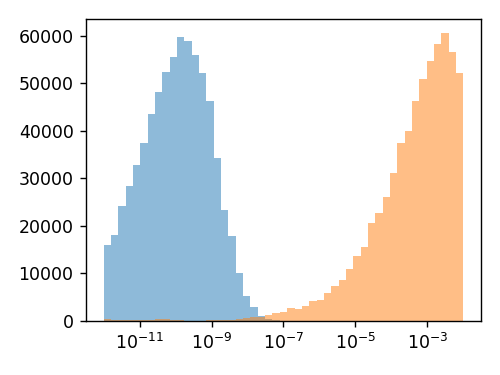

In [36]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(nd_eri0_ao.ravel() - eri1_ao.ravel()), bins=np.logspace(np.log10(1e-12), np.log10(1e-2), 50), alpha=0.5)
ax.hist(abs(nd_eri0_ao.ravel()), bins=np.logspace(np.log10(1e-12), np.log10(1e-2), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

## 电子态能量导数

有了上面的准备工作之后，我们就可以求取电子态能量在原子核坐标分量下的导数 `E_1` $\partial_{A_t} E_\mathrm{elec}$ 了。在此之前，我们对任意变量的能量导数作叙述。

根据

$$
E_\mathrm{elec} = h_{\mu \nu} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{1}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda) D_{\kappa \lambda}
$$

我们有

$$
\begin{align}
\frac{\partial E_\mathrm{elec}}{\partial \mathbb{A}}
&= \frac{\partial h_{\mu \nu}}{\partial \mathbb{A}} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} \frac{\partial (\mu \nu | \kappa \lambda)}{\partial \mathbb{A}} D_{\kappa \lambda} - \frac{1}{4} D_{\mu \nu} \frac{\partial (\mu \kappa | \nu \lambda)}{\partial \mathbb{A}} D_{\kappa \lambda} + F_{\mu \nu} \frac{\partial D_{\mu \nu}}{\partial \mathbb{A}} \\
&= \left( h_{\mu \nu}^\mathbb{A} + \frac{1}{2} (\mu \nu | \kappa \lambda)^\mathbb{A} D_{\kappa \lambda} - \frac{1}{4} (\mu \kappa | \nu \lambda)^\mathbb{A} D_{\kappa \lambda} \right) D_{\mu \nu} - 2 F_{ij} S_{ij}^\mathbb{A}
\end{align}
$$

这与在上一篇文档求取 $S_{\mu \nu}^t$ 的推演非常类似，使用到的也几乎仅仅是链式法则。

关于 $F_{\mu \nu} \frac{\partial D_{\mu \nu}}{\partial \mathbb{A}}$ 一项是如何出现的，请参考上一份文档的 [任务 (3)](dip_rhf_skeleton.ipynb#任务-(3))。

<div class="alert alert-info">

**任务 (6)**

请证明

$$
\frac{\partial E_\mathrm{elec}}{\partial \mathbb{A}} \leftarrow F_{\mu \nu} \frac{\partial D_{\mu \nu}}{\partial \mathbb{A}} = - 2 F_{ij} S_{ij}^\mathbb{A}
$$

上式等式左对 $\mu, \nu$ 求和，等式右对 $i, j$ 求和。

</div>

上面的表达式对于 RHF 方法，是具有普适性的；因此，普适的 $\mathbb{A}$ 替换为特化的 $A_t$ 后，有电子态能量在原子核坐标分量下的导数

$$
\frac{\partial E_\mathrm{elec}}{\partial A_t} = \left( h_{\mu \nu}^{A_t} + \frac{1}{2} (\mu \nu | \kappa \lambda)^{A_t} D_{\kappa \lambda} - \frac{1}{4} (\mu \kappa | \nu \lambda)^{A_t} D_{\kappa \lambda} \right) D_{\mu \nu} - 2 F_{ij} S_{ij}^{A_t}
$$

为程序编写的方便，我们也可以拆开写为

$$
\frac{\partial E_\mathrm{elec}}{\partial A_t} = h_{\mu \nu}^{A_t} D_{\mu \nu} + \frac{1}{2} (\mu \nu | \kappa \lambda)^{A_t} D_{\mu \nu} D_{\kappa \lambda} - \frac{1}{4} (\mu \kappa | \nu \lambda)^{A_t} D_{\mu \nu} D_{\kappa \lambda}  - 2 F_{ij} S_{ij}^{A_t}
$$

该导数可以在程序中写作 `E_1_elec` $\partial_{A_t} E_\mathrm{elec}$；在此之前我们先生成 `S_1_mo` $S_{ij}^{A_t}$：

$$
S_{pq}^{A_t} = C_{\mu p} S_{\mu \nu}^{A_t} C_{\nu q}
$$

In [37]:
S_1_mo = np.einsum("up, Atuv, vq -> Atpq", C, S_1_ao, C)

In [38]:
E_1_elec = (
    +        np.einsum("Atuv, uv -> At", H_1_ao, D)
    + 0.5  * np.einsum("Atuvkl, uv, kl -> At", eri1_ao, D, D)
    - 0.25 * np.einsum("Atukvl, uv, kl -> At", eri1_ao, D, D)
    - 2    * np.einsum("ij, Atij -> At", F_0_mo[so, so], S_1_mo[:, :, so, so])
)
E_1_elec

array([[-1.13535, -0.32849, -8.72549],
       [-0.34059, -3.84987,  8.36218],
       [ 1.50674, -0.01438, -0.37139],
       [-0.03081,  4.19273,  0.73471]])

通过数值导数，我们也能得到 `nd_E_0_elec` $\partial_{A_t} E_\mathrm{elec}$：

In [39]:
nd_E_0_elec = NumericDiff(gradn, lambda gradh: gradh.scf_eng.energy_elec()[0]).derivative.reshape(natm, 3)
nd_E_0_elec

array([[-1.13535, -0.32849, -8.72549],
       [-0.34059, -3.84987,  8.36218],
       [ 1.50674, -0.01438, -0.37139],
       [-0.03081,  4.19273,  0.73471]])

下面我们对比数值导数与解析导数之间的差别。由于能量梯度是最终的结果，我们用更严苛的 np.allclose 来验证结果：

In [40]:
np.allclose(E_1_elec, nd_E_0_elec)

True

## 原子核互斥能导数

这一段我们暂时不用 Einstein Summation。

我们回顾原子核互斥能的计算：

$$
E_\mathrm{nuc} = \frac{1}{2} \sum_{M N} \frac{Z_M Z_N}{| \boldsymbol{M} - \boldsymbol{N} |} = \frac{1}{2} \sum_{M N} Z_{MN} r_{MN}^{-1}
$$

其中，$M, N$ 为原子角标，

$$
\begin{align}
Z_{MN} &= Z_M Z_N \\
r_{MN} &= | \boldsymbol{M} - \boldsymbol{N} |
\end{align}
$$

现在，我们对上式作关于 $A_t$ 的导数：

$$
\frac{\partial E_\mathrm{nuc}}{\partial A_t} = \frac{1}{2} \sum_{M N} Z_{MN} \frac{\partial}{\partial A_t} r_{MN}^{-1}
$$

到这里我们先回顾 $r_{MN}$ 的定义：

$$
r_{MN} = \sqrt{\sum_{t} (M_t - N_t)^2}
$$

因此，

$$
\begin{align}
\frac{\partial}{\partial A_t} r_{MN}^{-1}
&= \frac{\partial}{\partial A_t} \left( \sum_t (M_t - N_t)^2 \right)^{-1/2} \\
&= - \frac{1}{2} \left( \sum_t (M_t - N_t)^2 \right)^{-3/2} \frac{\partial}{\partial A_t} \sum_t (M_t - N_t)^2 \\
&= - r_{MN}^{-3} (M_t - N_t) (\delta_{MA} - \delta_{NA})
\end{align}
$$

为了程序实现的便利，我们会定义

$$
V_{MNt} = M_t - N_t
$$

该张量会具有 $V_{MNt} = - V_{NMt}$ 的反对称性质。因此，

$$
\begin{align}
\frac{\partial E_\mathrm{nuc}}{\partial A_t}
&= - \frac{1}{2} \sum_{M N} Z_{MN} r_{MN}^{-3} V_{MNt} (\delta_{MA} - \delta_{NA}) \\
&= - \frac{1}{2} \left( \sum_{N} Z_{AN} r_{AN}^{-3} V_{ANt} - \sum_{M} Z_{MA} r_{MA}^{-3/2} V_{MAt} \right) \\
&= - \sum_M Z_{AM} r_{AM}^{-3} V_{AMt}
\end{align}
$$

在程序中，我们定义

- `nuc_Z` $Z_{MN}$

- `nuc_rinv` $r_{MN}^{-1}$

- `nuc_V` $V_{MNt}$

In [41]:
nuc_Z = np.einsum("M, N -> MN", mol.atom_charges(), mol.atom_charges())
nuc_V = lib.direct_sum("Mt - Nt -> MNt", mol.atom_coords(), mol.atom_coords())
nuc_rinv = 1 / (np.linalg.norm(nuc_V, axis=2) + np.diag([np.inf] * natm))

那么，程序实现 `E_1_nuc` $\partial_{A_t} E_\mathrm{nuc}$ 可以表示如下：

In [42]:
E_1_nuc = - np.einsum("AM, AM, AMt -> At", nuc_Z, nuc_rinv**3, nuc_V)
E_1_nuc

array([[ 0.99566,  0.34575,  8.70615],
       [ 0.35202,  4.57189, -8.31727],
       [-1.38536,  0.01759,  0.3897 ],
       [ 0.03768, -4.93523, -0.77858]])

我们也可以用过数值导数方式给出 `nd_E_0_nuc` $\partial_{A_t} E_\mathrm{nuc}$：

In [43]:
nd_E_0_nuc = NumericDiff(gradn, lambda gradh: gradh.scf_eng.energy_nuc()).derivative.reshape(natm, 3)
nd_E_0_nuc

array([[ 0.99566,  0.34575,  8.70615],
       [ 0.35202,  4.5719 , -8.31727],
       [-1.38536,  0.01759,  0.3897 ],
       [ 0.03768, -4.93523, -0.77858]])

可以验证，数值导数与解析导数之间近乎相等：

In [44]:
np.allclose(E_1_nuc, nd_E_0_nuc)

True

## 分子总能量导数

综上，整个分子最终的能量导数为 `E_1`

$$
\frac{\partial E}{\partial A_t} = \frac{\partial E_\mathrm{elec}}{\partial A_t} + \frac{\partial E_\mathrm{nuc}}{\partial A_t}
$$

In [45]:
E_1 = E_1_elec + E_1_nuc
E_1

array([[-0.13969,  0.01726, -0.01934],
       [ 0.01143,  0.72202,  0.04491],
       [ 0.12139,  0.00321,  0.01831],
       [ 0.00688, -0.7425 , -0.04387]])

可见，分子总能量的导数总体来说并不大；这是因为电子态能量导数与核排斥能导数两个相当大的矩阵正负抵消导致的。

上述导数在 pyxdh 中，以 `gradh.E_1` property 呈现：

In [46]:
np.allclose(E_1.ravel(), gradh.E_1.ravel())

True

最后，我们通过验证数值导数 `nd_E_0` $\partial_{A_t} E$ 的方式，来确定我们方才推演的解析导数确实是正确的：

In [47]:
nd_E_0 = NumericDiff(gradn, lambda gradh: gradh.eng).derivative.reshape(natm, 3)
nd_E_0

array([[-0.13969,  0.01726, -0.01934],
       [ 0.01143,  0.72202,  0.04491],
       [ 0.12139,  0.00321,  0.01831],
       [ 0.00688, -0.7425 , -0.04387]])

In [48]:
np.allclose(E_1, nd_E_0)

True

## 参考任务解答

### 任务 (1)

首先，我们指出，$\langle \partial_t \mu_A | \nu_A \rangle$ 并不为零；譬如对于原子 $A$ 代表第 1 个氢原子 (索引 2) 的情形，我们给出 $\langle \partial_z \mu_A | \nu_A \rangle$：

In [49]:
sA = mol_slice(1)
int1e_ipovlp[2, sA, sA]

array([[-0.     ,  0.     , -0.     ,  0.     ,  0.     , -1.51402,  0.     ,  0.     , -0.16843],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.68687,  0.     ,  0.     , -0.6159 ],
       [-0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.2606 ,  0.     ,  0.     , -0.51962],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 1.51402,  0.68687,  0.2606 ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.16843,  0.6159 ,  0.51962,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ]])

但我们注意到这是一个反对称矩阵，因此求 $\langle \partial_z \mu_A | \nu_A \rangle$ 加上其转置即 $\langle \mu_A | \partial_z \nu_A \rangle$ 后，该矩阵就变成了零值了。

事实上，$\langle \partial_z \mu | \nu \rangle$ 作为张量本身就是反对称的，或者说

$$
\langle \partial_z \mu | \nu \rangle = - \langle \mu | \partial_z \nu \rangle
$$

也可以说，$\partial_z$ 算符是反厄米的。

简单地说，使用分部积分法，

$$
\begin{align}
\langle \partial_z \mu | \nu \rangle
&= \int_{-\infty}^{+\infty} \int_{-\infty}^{+\infty} \int_{-\infty}^{+\infty} \frac{\partial \phi_\mu}{\partial_z} \phi_\nu \, \mathrm{d} z \, \mathrm{d} y \, \mathrm{d} x \\
&= \int_{-\infty}^{+\infty} \int_{-\infty}^{+\infty} \left( \phi_\mu \phi_\nu \big|_{z \rightarrow -\infty}^{+\infty} - \int_{-\infty}^{+\infty} \phi_\mu \frac{\partial \phi_\nu}{\partial_z} \, \mathrm{d} z \right) \, \mathrm{d} y \, \mathrm{d} x
\end{align}
$$

而我们知道，作为原子轨道基组的 Gaussian 函数具有当坐标距离中心无穷远时，函数取值为零的性质，即

$$
\lim_{z \rightarrow \pm \infty} \phi (x, y, z) = 0, \quad \forall x, y \in \mathbb{R}
$$

这条公式算是断言，我们就不作证明了。与其有关的问题是波函数 (或基组) 的平方可积性质。

那么，上式就化为了

$$
\langle \partial_z \mu | \nu \rangle = - \int_{-\infty}^{+\infty} \int_{-\infty}^{+\infty} \int_{-\infty}^{+\infty} \phi_\mu \frac{\partial \phi_\nu}{\partial_z} \, \mathrm{d} z \, \mathrm{d} y \, \mathrm{d} x = \langle \mu | \partial_z \nu \rangle
$$

显然这对其它两种分量的导数也适用；因此，

$$
\langle \partial_t \mu | \nu \rangle + \langle \mu | \partial_t \nu \rangle = \langle \partial_t \mu | \nu \rangle + \mathrm{swap} (\mu, \nu) = 0
$$

若 $\mu, \nu$ 被限定都在原子 $A$ 上，上式仍然成立，因此命题得证。

但上述的证明过程可能会让我们误认为，既然 $S_{\mu \nu}^t$ 就是通过 $\langle \partial_t \mu | \nu \rangle$ 生成的，那么看起来所有值都会是零。事实上，

$$
\langle \partial_t \mu_A | \nu_B \rangle + \langle \mu_B | \partial_t \nu_A \rangle \not\equiv 0
$$

这是因为，如果 $\mu$ 在 $A$ 原子上且 $\nu$ 在 $B$ 原子上，那么 $\langle \partial_t \mu_A | \nu_B \rangle \not\equiv 0$；但假使现在 $A \neq B$，那么一定有 $\langle \mu_B | \partial_t \nu_A \rangle = 0$；因此，上式的左边未必为零。这里 $\not\equiv$ 符号的意义是未必为零。

### 任务 (2)

这是因为 $\hat t$ 算符是对电子坐标的导数；它与原子核完全无关，因此在原子核坐标分量 $A_t$ 下不可能有任何导数出现。

### 任务 (3)

待证等式为

$$
\frac{\partial}{\partial t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} = - \frac{\partial}{\partial A_t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |}
$$

注意到我们可以写 (距离的定义是通过 $L_2$ Norm 给出的)

$$
| \boldsymbol{r} - \boldsymbol{A} | = \sqrt{\sum_{s} (s - A_s)^2}
$$

其中，$s$ 与 $t$ 一样代表坐标分量，$s \in \{ x, y, z \}$。

因此，等式左边有：

$$
\begin{align}
\frac{\partial}{\partial t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |}
&= Z_A \frac{\partial}{\partial t} \left( \sum_{s} (s - A_s)^2 \right)^{- 1/2} \\
&= - \frac{1}{2} Z_A \left( \sum_{s} (s - A_s)^2 \right)^{- 3/2} \frac{\partial}{\partial t} \sum_{s} (s - A_s)^2 \\
&= - \frac{1}{2} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |^3} \frac{\partial}{\partial t} (t - A_t)^2 \\
&= - \frac{Z_A (t - A_t)}{| \boldsymbol{r} - \boldsymbol{A} |^3}
\end{align}
$$

其中，第三个等号利用到了当 $s \in \{ y, z \}$ 时，$s$ 与被求导变量 $t$ 无关，因此导数必然为零的性质。

仿照上面的推导，应当能发现

$$
\frac{\partial}{\partial A_t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} = \frac{Z_A (t - A_t)}{| \boldsymbol{r} - \boldsymbol{A} |^3}
$$

因此，命题得证。

### 任务 (4)

思路同任务 (1)。这里就不详细展开了。

### 任务 (5)

因为分部积分只适用于被偏导变量与被积分的微元变量相同的情形。在

$$
\int \phi_\mu \phi_\nu \frac{\partial}{\partial A_t} \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} \, \mathrm{d} \boldsymbol{r}
\not \equiv - \int \frac{\partial}{\partial A_t} (\phi_\mu \phi_\nu) \cdot \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} \, \mathrm{d} \boldsymbol{r}
$$

中，被偏导变量是 $A_t$，被积分微元是三维向量 $\boldsymbol{r}$，或者是三重积分下的三个变量 $(x, y, z)$。$A_t$ 与 $(x, y, z)$ 之间毫无关系，因此不能套用分部积分的公式推演思路。

进一步说，$\partial_t$ 一般来说是反厄米算符，而 $\partial_{A_t}$ 一般不具有厄米或反厄米性质。

### 任务 (6)

下述的推演过程与上一篇文档的 [任务 (4)](dip_rhf_skeleton.ipynb#任务-(4)) 非常相似。

待证明等式为

$$
\frac{\partial E_\mathrm{elec}}{\partial \mathbb{A}} \leftarrow F_{\mu \nu} \frac{\partial D_{\mu \nu}}{\partial \mathbb{A}} = - 2 F_{ij} S_{ij}^\mathbb{A}
$$

首先，通过链式法则，有

$$
\frac{\partial D_{\mu \nu}}{\partial \mathbb{A}}
= \frac{\partial (2 C_{\mu i} C_{\nu i})}{\partial \mathbb{A}}
= 2 \left( \frac{\partial (C_{\mu i})}{\partial \mathbb{A}} C_{\nu i} + C_{\mu i} \frac{\partial (C_{\nu i})}{\partial \mathbb{A}} \right)
$$

根据 U 矩阵定义，有

$$
\frac{\partial D_{\mu \nu}}{\partial \mathbb{A}} = 2 \big( C_{\mu m} U_{mi}^\mathbb{A} C_{\nu i} + C_{\nu m} U_{mi}^\mathbb{A} C_{\mu i} \big)
$$

上式与 $F_{\mu \nu}$ 缩并后，有

$$
\begin{align}
\frac{\partial E_\mathrm{elec}}{\partial \mathbb{A}} \leftarrow F_{\mu \nu} \frac{\partial D_{\mu \nu}}{\partial \mathbb{A}}
&= 2 \big( C_{\mu m} F_{\mu \nu} C_{\nu i} U_{mi}^\mathbb{A} + C_{\mu i} F_{\mu \nu} C_{\nu m} U_{mi}^\mathbb{A} \big) \\
&= 2 (F_{mi} + F_{im}) U_{mi}^\mathbb{A} \\
&= 4 F_{mi} U_{mi}^\mathbb{A}
\end{align}
$$

其中，最后一个等号利用了 Fock 矩阵的对称性。

对于 RHF 而言，Fock 矩阵的非占-占据部分为零，即 $F_{ai} = 0$，因此上式中全轨道角标 $m$ 只在处于占据轨道时才有值；因此

$$
\begin{align}
\frac{\partial E_\mathrm{elec}}{\partial \mathbb{A}} \leftarrow F_{\mu \nu} \frac{\partial D_{\mu \nu}}{\partial \mathbb{A}}
&= 4 F_{mi} U_{mi}^\mathbb{A} = 2 F_{ji} U_{ji}^\mathbb{A} \\
&= 2 \big( F_{ij} U_{ij}^\mathbb{A} + F_{ji} U_{ji}^\mathbb{A} \big) \\
&= 2 F_{ij} (U_{ij}^\mathbb{A} + U_{ji}^\mathbb{A}) \\
&= -2 F_{ij} S_{ij}^\mathbb{A}
\end{align}
$$

上式的第 2 行利用了求和角标可交换的特性，第 3 行利用了 Fock 矩阵的对称性，第 4 行利用了

$$
U_{ij}^\mathbb{A} + U_{ji}^\mathbb{A} + S_{ij}^\mathbb{A} = 0
$$